In [7]:
# Step 1: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [11]:
# Step 2: Import Dataset
from google.colab import files
uploaded = files.upload()
df = pd.read_csv('adult.csv', na_values=' ?')
df.columns = df.columns.str.strip()
df.columns = df.columns.str.replace('[.-]', '_', regex=True)

df.head()

Saving adult.csv to adult (1).csv


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [12]:
# Step 3: Exploratory Data Analysis
print("Dataset Information:")
df.info()
print("\n-----------------------------------\n")

print("Statistical Summary:")
print(df.describe())
print("\n-----------------------------------\n")

print("Missing Values Check:")
print(df.isnull().sum())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB

-----------------------------------

Statistical Summary:
             

In [14]:
# Step 4: Feature Engineering & Preprocessing

# Impute missing values for categorical columns with the mode
# Note the use of the new column names with underscores
for col in ['workclass', 'occupation', 'native_country']:
    # This line is corrected to avoid the FutureWarning
    df[col] = df[col].fillna(df[col].mode()[0])

# Drop columns that are redundant or not useful
# 'education' is represented by 'education_num'
df = df.drop(['education', 'fnlwgt'], axis=1)

# Convert the target variable 'income' to binary (0 and 1)
df['income'] = df['income'].map({'<=50K': 0, '>50K': 1})

# One-Hot Encode the remaining categorical features
categorical_cols = df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True, dtype=int)

print("\nData after cleaning and conversion:")
print(df.head())
print("\nTotal missing values after imputation:", df.isnull().sum().sum())


Data after cleaning and conversion:
   age  education_num  capital_gain  capital_loss  hours_per_week  income  \
0   90              9             0          4356              40       0   
1   82              9             0          4356              18       0   
2   66             10             0          4356              40       0   
3   54              4             0          3900              40       0   
4   41             10             0          3900              40       0   

   workclass_Federal-gov  workclass_Local-gov  workclass_Never-worked  \
0                      0                    0                       0   
1                      0                    0                       0   
2                      0                    0                       0   
3                      0                    0                       0   
4                      0                    0                       0   

   workclass_Private  ...  native_country_Portugal  \
0      

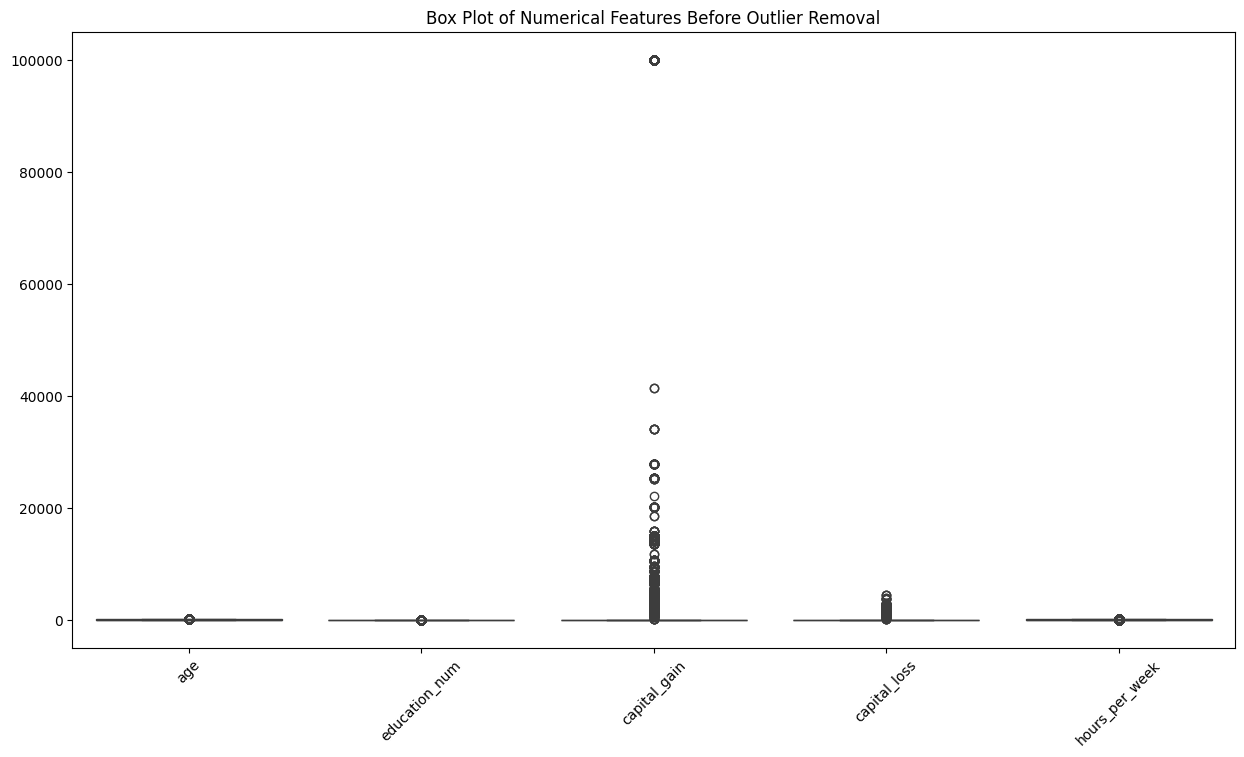

Original number of samples: 32561
Number of samples after removing outliers: 19619


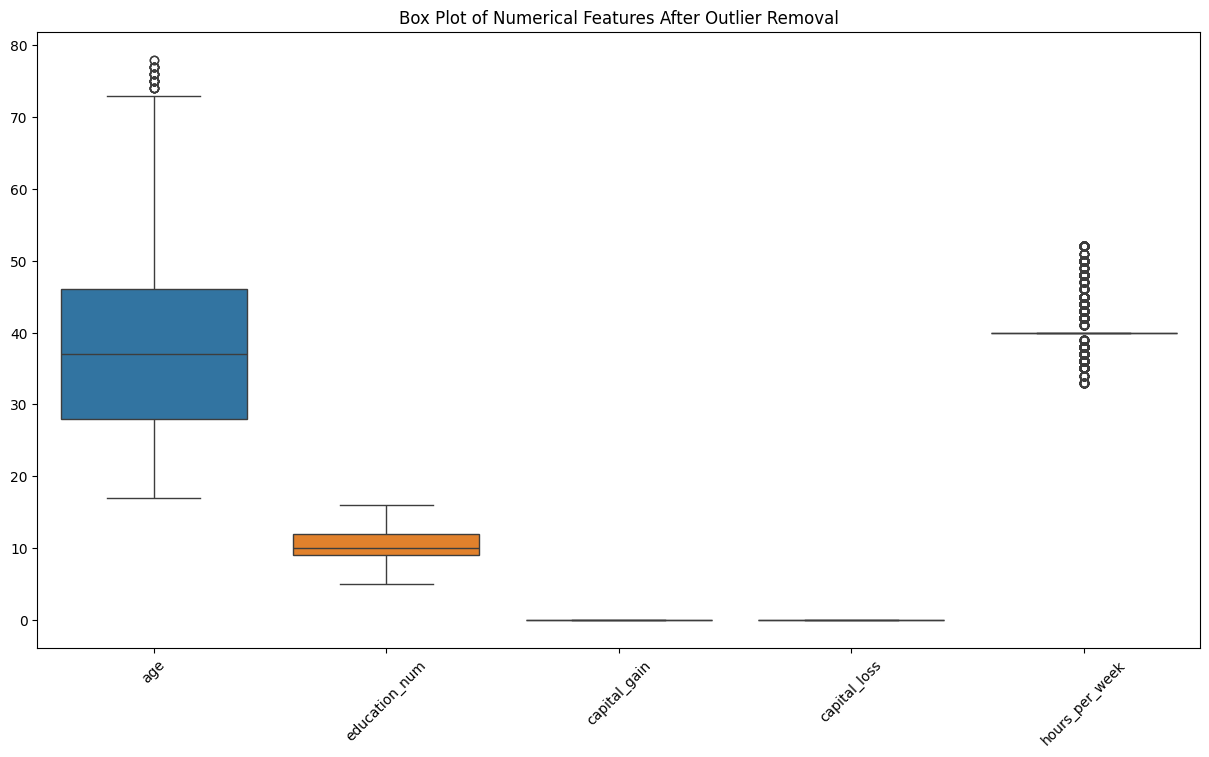

In [15]:
# Step 5: Check and drop the outliers
# Using the new, clean numerical column names
numerical_cols = ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']

# Use box plot to show before removal of outliers
plt.figure(figsize=(15, 8))
sns.boxplot(data=df[numerical_cols])
plt.title('Box Plot of Numerical Features Before Outlier Removal')
plt.xticks(rotation=45)
plt.show()

# Outlier removal using IQR method
Q1 = df[numerical_cols].quantile(0.25)
Q3 = df[numerical_cols].quantile(0.75)
IQR = Q3 - Q1
outlier_condition = ~((df[numerical_cols] < (Q1 - 1.5 * IQR)) | (df[numerical_cols] > (Q3 + 1.5 * IQR))).any(axis=1)

df_cleaned = df[outlier_condition]

print(f"Original number of samples: {len(df)}")
print(f"Number of samples after removing outliers: {len(df_cleaned)}")

# Use box plot to show after removal of outliers
plt.figure(figsize=(15, 8))
sns.boxplot(data=df_cleaned[numerical_cols])
plt.title('Box Plot of Numerical Features After Outlier Removal')
plt.xticks(rotation=45)
plt.show()

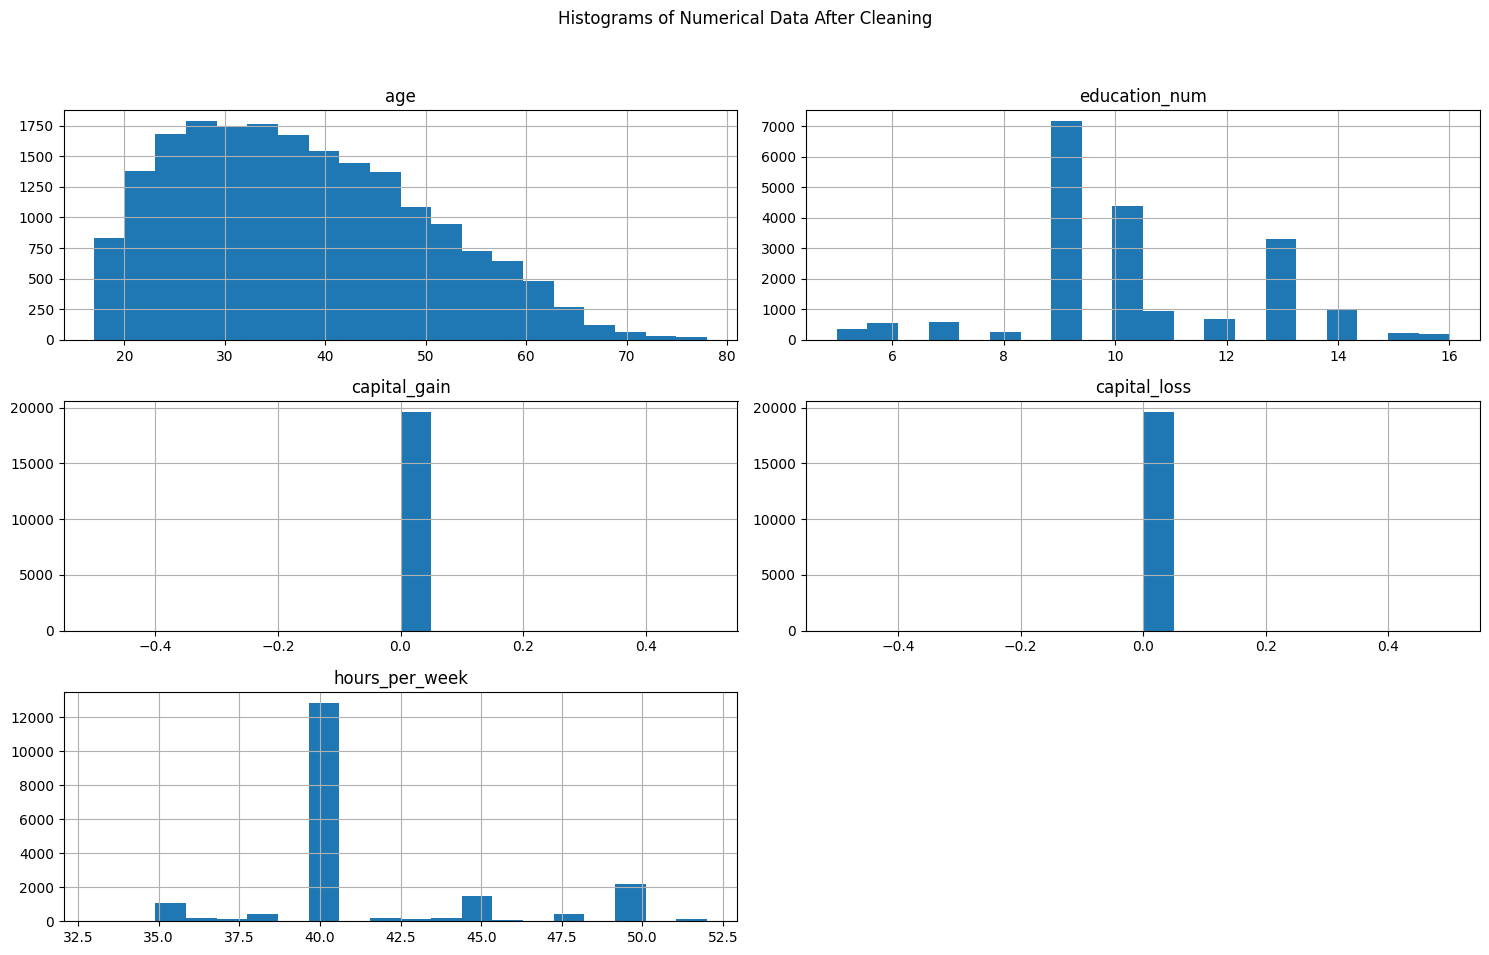

In [16]:
# Step 6: Use histograms to show the distribution of the data
df_cleaned[numerical_cols].hist(bins=20, figsize=(15, 10))
plt.suptitle('Histograms of Numerical Data After Cleaning')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [17]:
# Step 7: Declare feature vector and target variable
X = df_cleaned.drop('income', axis=1)
y = df_cleaned['income']

In [18]:
# Step 8: Split data into separate training and test set
# We use stratify=y to maintain the same proportion of target classes in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [19]:
# Step 9: Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
# Step 10: Model training with Random Forest
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, oob_score=True)
rf_classifier.fit(X_train_scaled, y_train)

# The Out-of-Bag score is an internal estimate of the model's performance
print(f'Out-of-Bag Score: {rf_classifier.oob_score_:.4f}')

Out-of-Bag Score: 0.8165


In [21]:
# Step 11: Predict results and check accuracy score
y_pred = rf_classifier.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy on Test Set: {accuracy * 100:.2f}%')

Accuracy on Test Set: 82.01%


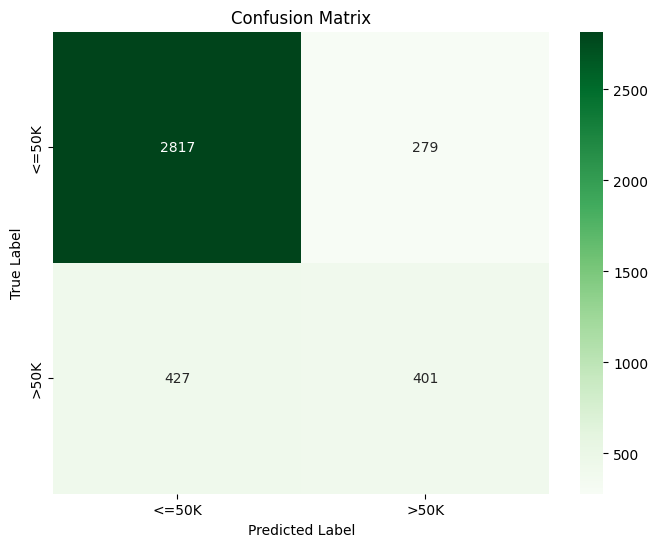

In [22]:
# Step 12: Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens',
            xticklabels=['<=50K', '>50K'],
            yticklabels=['<=50K', '>50K'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

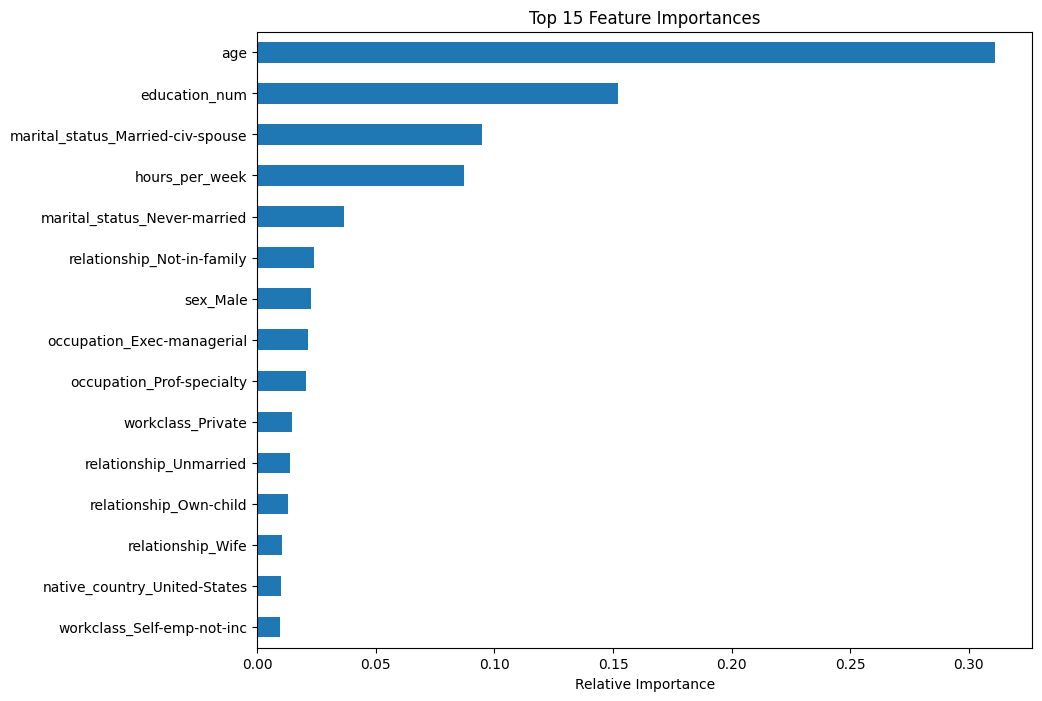

In [23]:
# Step 13: Visualization of Feature Importance
feature_importances = pd.Series(rf_classifier.feature_importances_, index=X.columns)

plt.figure(figsize=(10, 8))
feature_importances.nlargest(15).sort_values().plot(kind='barh')
plt.title('Top 15 Feature Importances')
plt.xlabel('Relative Importance')
plt.show()